In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

#### read csv files from kaggle 

In [3]:
df_gemini_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_gemini_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')

#### convert columns to datetime

In [4]:
df_gemini_price_d['Date'] = pd.to_datetime(df_gemini_price_d['Date'])
df_gemini_price_1h['Date'] = pd.to_datetime(df_gemini_price_1h['Date'])

#### verify the range of datetime in dataframes

In [5]:
print('------------', 'df_gemini_price_d', '------------')
print(df_gemini_price_d['Date'].max())
print(df_gemini_price_d['Date'].min())
print('------------', 'df_gemini_price_1h', '------------')
print(df_gemini_price_1h['Date'].max())
print(df_gemini_price_1h['Date'].min())

------------ df_gemini_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_gemini_price_1h ------------
2020-04-09 00:00:00
2015-10-08 13:00:00


#### verify the numbers of lines in dataframes

In [6]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_gemini_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_gemini_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1646
------------ df_coinmarket_price_1h ------------
39468


In [7]:
class ExponentialSmoothingForecast(object):
    
    def __init__(self, df, percentage_train_size, periodicity):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.periodicity = periodicity
                
    def perform(self):
        
        best_params, train_size, y_train_predict = self.grid_search_model()
        
        array_pred = np.array([])
        
        date_test = self.df[train_size:].index
        count = 0
        
        for current_datetime in date_test:

            pred = self.prediction(best_params = best_params, current_datetime = current_datetime)
            array_pred = np.append(array_pred, pred)
#             print('current_datetime', current_datetime)
#             print('pred', pred)
            count += 1
            print(count/len(date_test)*100)
        
        date_train = self.df[:train_size].index
        y_train = self.df[:train_size]['Close'].values
        
        date_test = self.df[train_size:].index
        y_test = self.df[train_size:]['Close'].values
        
        data_train = {
          'date_train': date_train,
          'y_train': y_train,
          'y_train_predict': y_train_predict
        }

        data_test = {
            'date_test': date_test,
            'y_test': y_test,
            'y_test_predict': array_pred
        }

        df_train = pd.DataFrame(data_train)
        df_test = pd.DataFrame(data_test)

        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_test['y_test'],
                                                                        df_test['y_test_predict'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)

        
        return df_train, df_test
       
    def prediction(self, best_params, current_datetime):
        
        alpha = best_params['alpha']
        
        if self.periodicity == '1_day':
            train_datetime = (current_datetime - pd.Timedelta(days = 1))
            
        if self.periodicity == '1_hour':
            train_datetime = (current_datetime - pd.Timedelta(hours = 1))
        
        model = SimpleExpSmoothing(self.df[:train_datetime])
        fit_model = model.fit(smoothing_level = alpha)
                
        pred = fit_model.predict( start = current_datetime, end = current_datetime)

        return pred
    
    def grid_search_model(self):
        
        best_aic = np.inf
        train_size = int(len(self.df) * self.percentage_train_size)
        
        model = SimpleExpSmoothing(self.df[:train_size])
        list_alpha = [a/100 for a in range(0, 100, 10)]
        
        for alpha in list_alpha:
                
            fit_model = model.fit(smoothing_level = alpha)

            if fit_model.aic < best_aic:
                best_aic = fit_model.aic
                best_fit = fit_model
                best_params = {'alpha': alpha}
        
        print('AIC', best_aic, 'best_params', best_params)
        
        y_train_predict = best_fit.fittedvalues
               
        return best_params, train_size, y_train_predict
    
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None

        return mae, mape, mse, rmse, rmspe, r2, pearson
    

In [13]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

df = df.asfreq('D') # D or H

exponential_smoothing_forecast = ExponentialSmoothingForecast(df = df,
                                                              percentage_train_size = 0.80,
                                                              periodicity = '1_day'
                                                              )
df_train, df_test = exponential_smoothing_forecast.perform()

AIC 14956.811641042872 best_params {'alpha': 0.9}
0.30303030303030304
0.6060606060606061
0.9090909090909091
1.2121212121212122
1.5151515151515151
1.8181818181818181
2.1212121212121215
2.4242424242424243
2.727272727272727
3.0303030303030303
3.3333333333333335
3.6363636363636362
3.939393939393939
4.242424242424243
4.545454545454546
4.848484848484849
5.151515151515151
5.454545454545454
5.757575757575758
6.0606060606060606
6.363636363636363
6.666666666666667
6.969696969696971
7.2727272727272725
7.575757575757576
7.878787878787878
8.181818181818182
8.484848484848486
8.787878787878787
9.090909090909092
9.393939393939393
9.696969696969697
10.0
10.303030303030303
10.606060606060606
10.909090909090908
11.212121212121213
11.515151515151516
11.818181818181818
12.121212121212121
12.424242424242424
12.727272727272727
13.030303030303031
13.333333333333334
13.636363636363635
13.939393939393941
14.242424242424242
14.545454545454545
14.84848484848485
15.151515151515152
15.454545454545453
15.75757575757

In [18]:
# ES 1d
# AIC 14956.811641042872 best_params {'alpha': 0.9}
# mae 255.0775 mape 2.9498 mse 158088.9172 rmse 397.604 rmspe 5.2742 r2 0.9311 pearson 0.9654

In [15]:
# ES 1h
# AIC 265223.8722569918 best_params {'alpha': 0.9}
# mae 43.8527 mape 0.5044 mse 6859.6071 rmse 82.8227 rmspe 1.0039 r2 0.997 pearson 0.9985

In [14]:
# df_train.tail()
df_test.head()

# df_train.to_csv('train_es_1d.csv', sep = "\t", index = False)
df_test.to_csv('test_es_1d.csv', sep = "\t", index = False)
# pd.read_csv('train_es_1d.csv', sep = "\t")
pd.read_csv('test_es_1d.csv', sep = "\t")

# df_train.to_csv('train_es_1h.csv', sep = "\t", index = False)
# df_test.to_csv('test_es_1h.csv', sep = "\t", index = False)
# pd.read_csv('train_es_1h.csv', sep = "\t")
# pd.read_csv('test_es_1h.csv', sep = "\t")

,date_test,y_test,y_test_predict
0,2019-05-16,7881.38,8175.612878
1,2019-05-17,7361.92,7910.803288
2,2019-05-18,7262.52,7416.808329
3,2019-05-19,8192.44,7277.948833
4,2019-05-20,8003.97,8100.990883
...,...,...,...
325,2020-04-05,6775.21,6857.709897
326,2020-04-06,7336.96,6783.459990
327,2020-04-07,7201.81,7281.609999
328,2020-04-08,7369.60,7209.790000


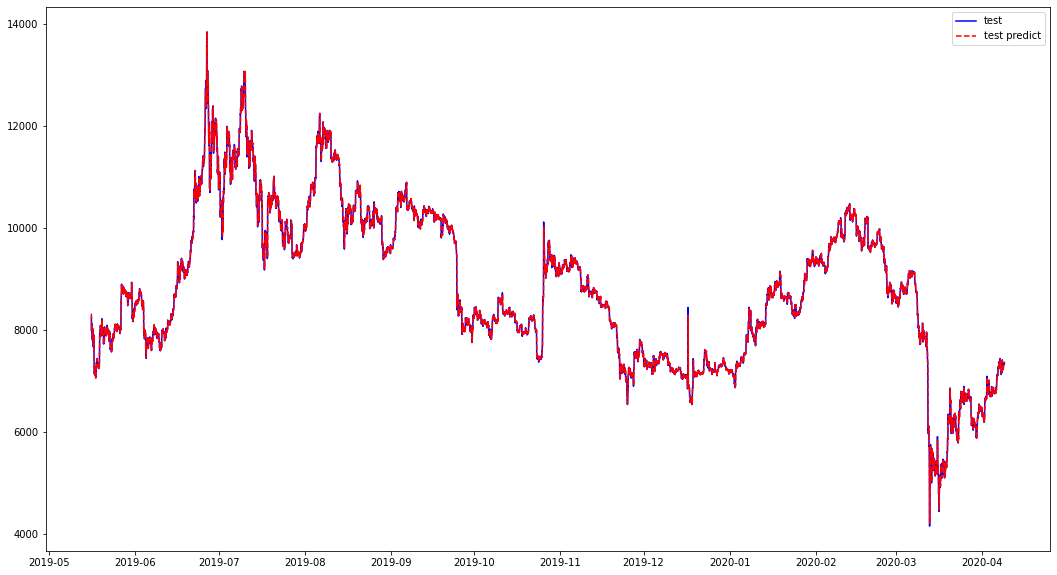

In [12]:
fig, ax = plt.subplots(figsize=(18, 10))

# ax.plot(df_train['date_train'], df_train['y_train'], label = 'train', color="blue")
# ax.plot(df_train['date_train'], df_train['y_train_predict'], '--', label = 'train predict', color="red")

ax.plot(df_test['date_test'], df_test['y_test'], label = 'test', color="blue")
ax.plot(df_test['date_test'], df_test['y_test_predict'], '--', label = 'test predict', color="red")

ax.legend()
plt.show()